<a href="https://colab.research.google.com/github/amrahmani/Marketing/blob/main/AIMarketing_Ch9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Hands-On Activities:**

**Objective:** Implement network analysis, small-world detection, community detection with PyTorch, and influence analysis

**Dataset:** https://www.kaggle.com/datasets/kazanova/sentiment140/data

**Feature Descriptions:**

This is the **Sentiment140 dataset**, a collection of 1.6 million tweets obtained via the Twitter API.
These tweets are annotated for sentiment detection and include **6 distinct features**.

**target**: the polarity of the tweet **(0 = negative, 2 = neutral, 4 = positive)**

**ids:** The id of the tweet ( 2087)

**date:** The date of the tweet (Sat May 16 23:58:44 UTC 2009)

**flag:** **`1)`** flag: the query (*CocaCola*): You searched for tweets mentioning "CocaCola" to understand sentiment around the brand. **`2)`** flag: The query (*@elonmusk*): If you were specifically pulling tweets mentioning a particular user. **`3)`** flag: The query (*#WorldCup*): Tweets related to a major event's hashtag. **`4)`** If there is no query, then this value is *NO_QUERY*.

**user:** The user that tweeted (Karoli)

**text:** The text of the tweet (CocaCola is cool)

**Download the Twitter Dataset from Kaggle**

In [ ]:
from google.colab import files
files.upload() # This will open a file picker. Select your kaggle.json file.

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"amirmasoudrahmani","key":"83083c6673953a54498441b57baeb137"}'}

In [ ]:
!pip install -q kaggle
!mkdir -p ~/.kaggle/
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls -al

total 16
drwxr-xr-x 1 root root 4096 Jun 27 05:00 .
drwxr-xr-x 1 root root 4096 Jun 27 04:57 ..
drwxr-xr-x 4 root root 4096 Jun 25 13:36 .config
drwxr-xr-x 1 root root 4096 Jun 25 13:36 sample_data


In [ ]:
!kaggle datasets download -d kazanova/sentiment140 -p ./data/
!ls -al ./data/
!unzip ./data/sentiment140.zip -d ./data/

Dataset URL: https://www.kaggle.com/datasets/kazanova/sentiment140
License(s): other
sentiment140.zip: Skipping, found more recently modified local copy (use --force to force download)
total 82876
drwxr-xr-x 2 root root     4096 Jun 27 05:00 .
drwxr-xr-x 1 root root     4096 Jun 27 05:00 ..
-rw-r--r-- 1 root root 84855679 Sep 21  2019 sentiment140.zip
Archive:  ./data/sentiment140.zip
  inflating: ./data/training.1600000.processed.noemoticon.csv  


In [ ]:
!pip install torch-geometric

# Activity 1: Network Analysis
**Objective:** Build a Twitter interaction network and compute centrality metrics.

Create a directed graph.

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Dataset Preview:
   target         ids                          date      flag  \
0       0  1467810369  Mon Apr 06 22:19:45 PDT 2009  NO_QUERY   
1       0  1467810672  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY   
2       0  1467810917  Mon Apr 06 22:19:53 PDT 2009  NO_QUERY   
3       0  1467811184  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   
4       0  1467811193  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   

              user                                               text  
0  _TheSpecialOne_  @switchfoot http://twitpic.com/2y1zl - Awww, t...  
1    scotthamilton  is upset that he can't update his Facebook by ...  
2         mattycus  @Kenichan I dived many times for the ball. Man...  
3          ElleCTF    my whole body feels itchy and like its on fire   
4           Karoli  @nationwideclass no, it's not behaving at all....  

Preprocessed Data (First 5 Rows):
                    user  user_id         mentions  target  \
541200   LaLaLindsey0609      807  [chrishasboobs]       0   
7

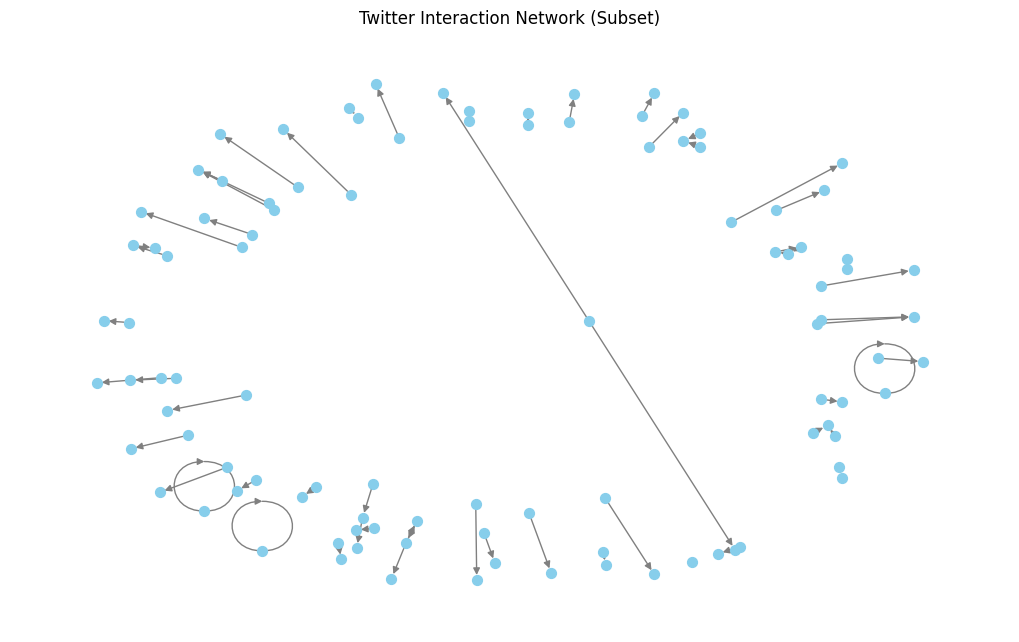

In [ ]:
# Dataset: Twitter Sentiment140 Dataset
# Path: ./data/training.1600000.processed.noemoticon.csv (local file with latin1 encoding)
# Objective: Implement network analysis, small-world detection, community detection with PyTorch, and influence analysis
# Tasks: Activity 1 (Network Analysis), Activity 2 (Small-World Detection), Activity 3 (Community Detection with GNN), Activity 4 (Influence Analysis)

# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import re
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
import torch
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import silhouette_score

# Download VADER lexicon for sentiment analysis
nltk.download('vader_lexicon')

# Load and Preprocess the Dataset
# Load Twitter dataset with specified columns and latin1 encoding
df = pd.read_csv('./data/training.1600000.processed.noemoticon.csv', encoding='latin1',
                 names=['target', 'ids', 'date', 'flag', 'user', 'text'])

# Print first 5 rows to understand structure
print("Dataset Preview:")
print(df.head())

# Handle missing values: Drop rows with missing user or text
df = df.dropna(subset=['user', 'text'])

# Filter to a manageable subset (e.g., 10,000 tweets) for computational efficiency
df = df.sample(n=10000, random_state=42)

# Extract mentions from tweet text using regex
# re: This refers to Python's built-in re module, which provides regular expression operations.
# Regular expressions are a powerful tool for pattern matching and text manipulation.
def extract_mentions(text):
    return re.findall(r'@(\w+)', text)

df['mentions'] = df['text'].apply(extract_mentions)

# Filter tweets with at least one mention for network analysis
df = df[df['mentions'].apply(len) > 0]

# Encode user IDs for graph construction
# LabelEncoder, the le object will learn a mapping from unique categorical values (in this case, unique usernames) to unique numerical integers.
le = LabelEncoder()
df['user_id'] = le.fit_transform(df['user'])

# Print preprocessed data summary
print("\nPreprocessed Data (First 5 Rows):")
print(df[['user', 'user_id', 'mentions', 'target', 'text']].head())

# Activity 1: Network Analysis
# DiGraph stands for Directed Graph
# Twitter mentions: If A mentions B, it doesn't mean B mentions A back. This is a directed relationship.
G = nx.DiGraph()

# Add edges from mentions
# G.add_edge(source, target): This is the NetworkX method used to add a directed edge to the graph.
for _, row in df.iterrows():
    user = row['user_id']
    for mention in row['mentions']:
        if mention in le.classes_:
            mention_id = le.transform([mention])[0]
            G.add_edge(user, mention_id)

# Compute degree and PageRank centrality
degree_centrality = nx.degree_centrality(G)
# The value 0.85 is the original and most commonly used damping factor proposed by the creators of Google's PageRank algorithm.
pagerank_centrality = nx.pagerank(G, alpha=0.85)

# Get top 5 users by centrality
# normalized degree of centrality: Normalization divides a node's raw degree (the simple count of its connections) by the maximum possible number of connections it could have in the network.
# This makes the centrality score comparable across networks of different sizes.
# Raw Degree: If a user has 8 connections, their raw degree is 8.
# Maximum Possible Connections: In a network with N nodes, the maximum number of connections a single node can have is N-1 (it can connect to every other node in the network).
top_degree = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:5]
top_pagerank = sorted(pagerank_centrality.items(), key=lambda x: x[1], reverse=True)[:5]

# Decode user IDs to usernames
top_degree_users = [(le.inverse_transform([user_id])[0], score) for user_id, score in top_degree]
top_pagerank_users = [(le.inverse_transform([user_id])[0], score) for user_id, score in top_pagerank]

# Print centrality results
print("\nActivity 1: Network Analysis Results")
print("Top 5 Users by Degree Centrality:")
for user, score in top_degree_users:
    print(f"User: {user}, Degree Centrality: {score:.4f}")
print("Top 5 Users by PageRank Centrality:")
for user, score in top_pagerank_users:
    print(f"User: {user}, PageRank Centrality: {score:.4f}")

# Visualize network (subset of 100 nodes for clarity)
sub_G = G.subgraph(list(G.nodes())[:100])
plt.figure(figsize=(10, 6))
nx.draw(sub_G, with_labels=False, node_size=50, node_color='skyblue', edge_color='gray')
plt.title('Twitter Interaction Network (Subset)')
plt.show()

# Activity 2: Small-World Network Detection
**Objective:** Detect small-world properties by computing path lengths and clustering coefficients.

Calculate average path length (use largest strongly connected component for directed graph).


Activity 2: Small-World Network Detection Results
Average Path Length: 1.5000
Clustering Coefficient: 0.0076
Random Graph Clustering Coefficient: 0.0000
Small-World Property: Present


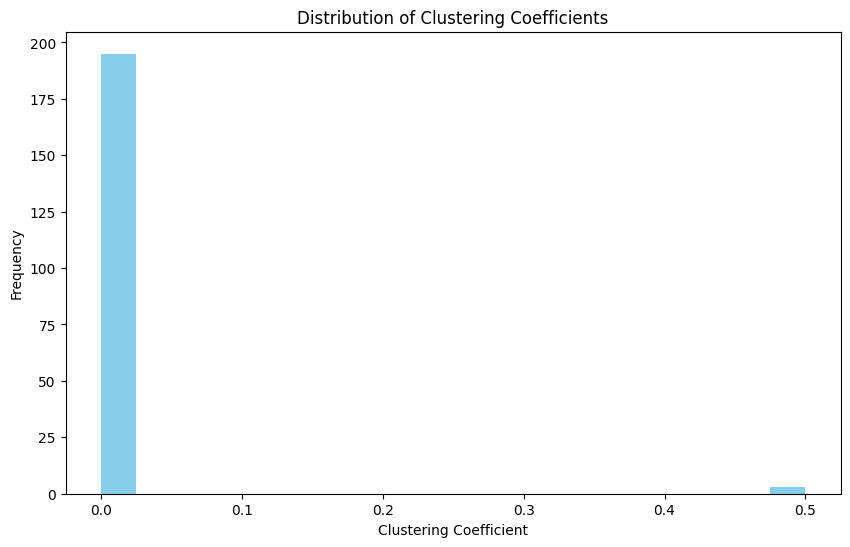

In [ ]:
# Strongly Connected Graph: In a directed graph, a graph is strongly connected if, for every pair of distinct nodes (u, v),
# there is a directed path from u to v AND a directed path from v to u.

# If the graph G is strongly connected, then it makes sense to calculate the average shortest path length for the entire graph.
# else if the graph G is not strongly connected, it means there are some nodes from which you cannot reach all other nodes (or vice versa).
# In such a graph, calculating the average shortest path length for the entire graph would be problematic.
# To address this, the code focuses on the largest strongly connected component (SCC).
if nx.is_strongly_connected(G):
    avg_path_length = nx.average_shortest_path_length(G)
else:
    largest_scc = max(nx.strongly_connected_components(G), key=len)
    G_scc = G.subgraph(largest_scc)
    avg_path_length = nx.average_shortest_path_length(G_scc)


# Calculate clustering coefficient
clustering_coeff = nx.average_clustering(G)

# Generate random graph for comparison
random_G = nx.gnp_random_graph(len(G.nodes()), len(G.edges()) / (len(G.nodes()) * (len(G.nodes()) - 1)), directed=True)
random_clustering = nx.average_clustering(random_G)

# Print results
print("\nActivity 2: Small-World Network Detection Results")
print(f"Average Path Length: {avg_path_length:.4f}")
print(f"Clustering Coefficient: {clustering_coeff:.4f}")
print(f"Random Graph Clustering Coefficient: {random_clustering:.4f}")
print(f"Small-World Property: {'Present' if clustering_coeff > random_clustering and avg_path_length < 6 else 'Not Present'}")

# Visualize clustering coefficient distribution
clustering_coeffs = list(nx.clustering(G).values())
plt.figure(figsize=(10, 6))
plt.hist(clustering_coeffs, bins=20, color='skyblue')
plt.title('Distribution of Clustering Coefficients')
plt.xlabel('Clustering Coefficient')
plt.ylabel('Frequency')
plt.show()

# Activity 3: Community Detection with PyTorch GNN
**Objective:** Detect communities using a Graph Neural Network (GNN).

Prepare graph data for PyTorch Geometric.

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([198, 1])) that is different to the input size (torch.Size([198, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0, Loss: 0.7294
Epoch 10, Loss: 0.0806
Epoch 20, Loss: 0.1119
Epoch 30, Loss: 0.0857
Epoch 40, Loss: 0.0788

Activity 3: Community Detection Results (GNN)
Community Sizes: [0, 20, 178]
Modularity Score: 0.2613


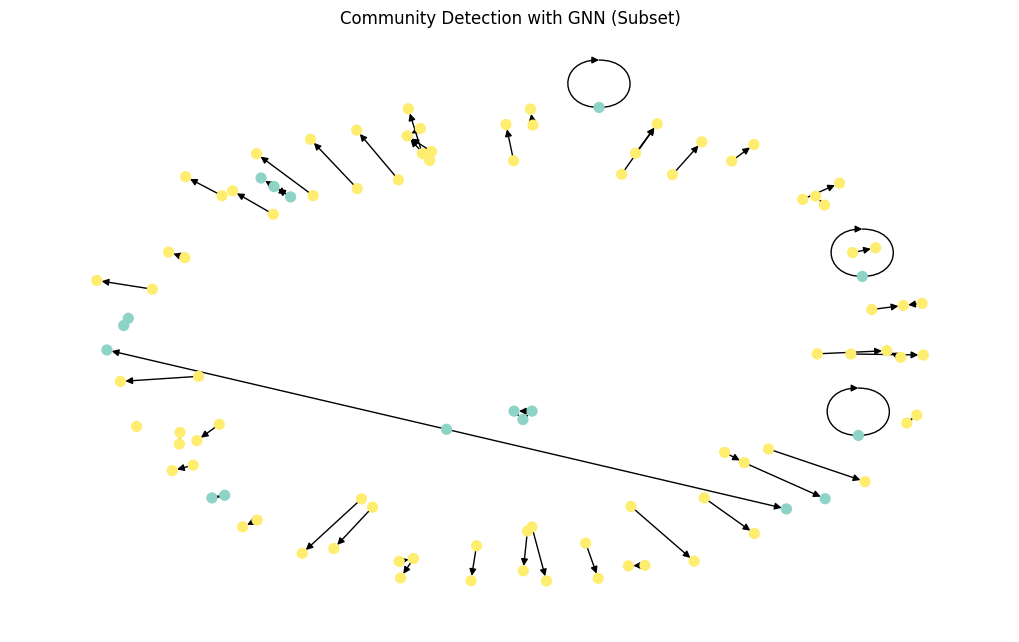

In [ ]:
nodes = list(G.nodes())
# create a lookup table (dictionary) where you can quickly find the numerical index for any given node, and vice versa
node_idx = {node: i for i, node in enumerate(nodes)}
# transform the edge list from G networkx graph into the specific edge_index tensor format required by PyTorch Geometric.
edge_index = torch.tensor([[node_idx[u], node_idx[v]] for u, v in G.edges()], dtype=torch.long).t().contiguous()

# Create node features (degree as a simple feature)
x = torch.tensor([G.degree(n) for n in nodes], dtype=torch.float).view(-1, 1)

# Create PyTorch Geometric data object
data = Data(x=x, edge_index=edge_index)

# Define GNN model
# Graph Convolutional Network (GCN)
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)
        return x

# Initialize model, optimizer, and loss
model = GCN(in_channels=1, hidden_channels=16, out_channels=3)  # 3 communities
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.MSELoss()

# Train GNN (simple unsupervised approach using node degrees as pseudo-labels)
model.train()
for epoch in range(50):
    optimizer.zero_grad()
    out = model(data)
    loss = criterion(out, data.x)  # Pseudo-loss for unsupervised learning
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

# Get community assignments
model.eval()
with torch.no_grad():
    embeddings = model(data)
    community_labels = embeddings.argmax(dim=1).numpy()

# Create a partition for modularity calculation including all nodes
all_nodes = list(G.nodes())
communities = [set() for _ in range(3)]
unclustered_nodes = set(all_nodes)

for i, label in enumerate(community_labels):
    node = nodes[i]
    if label < 3: # Assign to a community if clustered
        communities[label].add(node)
        unclustered_nodes.discard(node)

# Assign unclustered nodes to a separate community
if unclustered_nodes:
    communities.append(unclustered_nodes)


# Compute modularity
modularity = nx.algorithms.community.modularity(G, communities)


# Print community detection results
print("\nActivity 3: Community Detection Results (GNN)")
print(f"Community Sizes: {[len(c) for c in communities]}")
print(f"Modularity Score: {modularity:.4f}")

# Visualize communities (subset for clarity)
plt.figure(figsize=(10, 6))
# Map original node indices to the subset for visualization
sub_G_nodes = list(sub_G.nodes())
node_colors = [community_labels[nodes.index(n)] if nodes.index(n) < len(community_labels) else 3 for n in sub_G_nodes if n in nodes]


nx.draw(sub_G, node_color=node_colors, cmap=plt.cm.Set3, with_labels=False, node_size=50)
plt.title('Community Detection with GNN (Subset)')
plt.show()

# Activity 4: Influence Analysis
**Objective:** Identify influencers using PageRank and sentiment analysis.

Perform sentiment analysis with VADER.


Activity 4: Influence Analysis Results
Top 5 Influencers (PageRank * Sentiment):
User: whyinthehell, Influence Score: 0.0155
User: judez_xo, Influence Score: 0.0141
User: romaiel, Influence Score: 0.0089
User: PaulHarriott, Influence Score: 0.0085
User: unclewilco, Influence Score: 0.0075


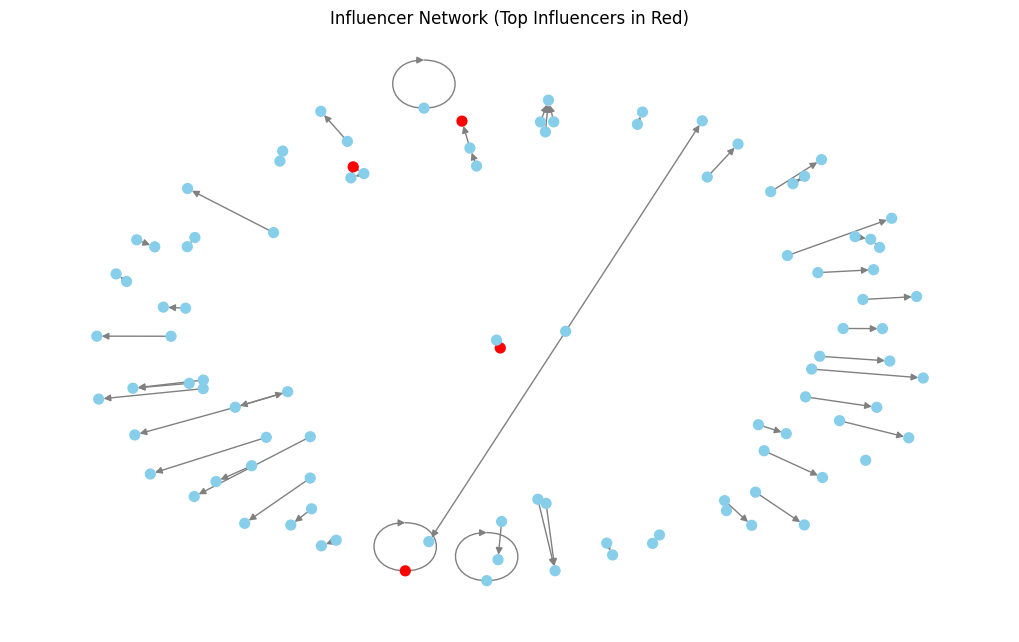

In [ ]:
sid = SentimentIntensityAnalyzer()
df['sentiment'] = df['text'].apply(lambda x: sid.polarity_scores(x)['compound'])

# Combine PageRank with positive sentiment
influencer_scores = {user: score for user, score in pagerank_centrality.items()}
user_sentiment = df.groupby('user_id')['sentiment'].mean().to_dict()
combined_scores = {user: influencer_scores[user] * user_sentiment.get(user, 0) for user in influencer_scores}

# Get top 5 influencers
top_influencers = sorted(combined_scores.items(), key=lambda x: x[1], reverse=True)[:5]
top_influencers_users = [(le.inverse_transform([user_id])[0], score) for user_id, score in top_influencers]

# Print influence results
print("\nActivity 4: Influence Analysis Results")
print("Top 5 Influencers (PageRank * Sentiment):")
for user, score in top_influencers_users:
    print(f"User: {user}, Influence Score: {score:.4f}")

# Visualize influencer network (highlight top influencers)
top_influencer_ids = [user_id for user_id, _ in top_influencers]
node_colors = ['red' if node in top_influencer_ids else 'skyblue' for node in sub_G.nodes()]
plt.figure(figsize=(10, 6))
nx.draw(sub_G, node_color=node_colors, with_labels=False, node_size=50, edge_color='gray')
plt.title('Influencer Network (Top Influencers in Red)')
plt.show()

**Activities**

**Task 1: Compute Betweenness Centrality:** Modify the network analysis code to compute betweenness centrality. Print top 5 users and visualize the network with high-betweenness nodes highlighted.
(Extends Activity 1: Adds a new centrality metric to identify users bridging communities.)

**Task 2: Dynamic Network Analysis:** Filter tweets by date to build weekly networks. Compute clustering coefficients for each and print trends to detect small-world property changes.
(Extends Activity 2: Incorporates temporal dynamics for marketing trends.)

**Task 3: Enhance GNN Model:** Increase GNN layers to 3 in community detection. Print new community sizes and modularity, and visualize updated clusters for comparison.
(Extends Activity 3: Enhances PyTorch GNN for deeper community analysis.)

**Task 4: Sentiment-Based Communities:** Group users by positive/negative tweet sentiment before GNN clustering. Print community sizes and modularity to assess sentiment-driven marketing segments.
(Extends Activity 3: Integrates sentiment for targeted marketing.)

**Task 5: Influence Cascade Analysis:** Track retweet cascades for top influencers. Print average cascade depth and visualize the top influencer’s cascade network for campaign impact.
(Extends Activity 4: Analyzes influence spread for marketing strategies.)